<a href="https://colab.research.google.com/github/RishKish411/CSC3831_Part_I/blob/main/Copy_of_CSC3831_Final_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC3831 Final Assessment - Part I: Data Engineering
Rishabh Kishore 190025854


In [124]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import sklearn.impute as sk_impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv', header=0)
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descriptions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [ ]:
# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation

### Data Understanding.
First and foremost let's load in the dataset and check its layout by printing the head and tail, from there we'll be able to gather which attributes we're working with, as well as the number of records within the dataset. The dataset appears to represent the houses' financial attributes, as well as their physical attributes (age and rooms) and their geographical locations.


In [3]:
print(houses_corrupted.head())
print(houses_corrupted.tail())

   median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1          1106.0      2401.0      1138.0     37.86    -122.22  
2           190.0         NaN       177.0     37.85    -122.24  
3           235.0         NaN       219.0     37.85    -122.25  
4           280.0       565.0       259.0     37.85    -122.25  
       median_house_value  median_income  housing_median_age  total_rooms  \
20635             78100.0         1.5603                25.0       1665.0   
20636            

We'd been made aware at the start of this task that this dataset was corrupted and upon brief inspection this display helps provide evidence for that. Even from this comparatively small representiation we can clearly see a number of missing values within attributes such as population and median age which would prompt one to investigate further especially as the missingness doesn't appear to follow a consistent pattern.

As the dataset appears to consist of over 20000 entries it will be a challenge to inspect the data directly, thus we shall be using graphing and statistical functions to help visualise and provide a thorough understanding of the data before we begin addressing anomalies.

array([[<Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>]], dtype=object)

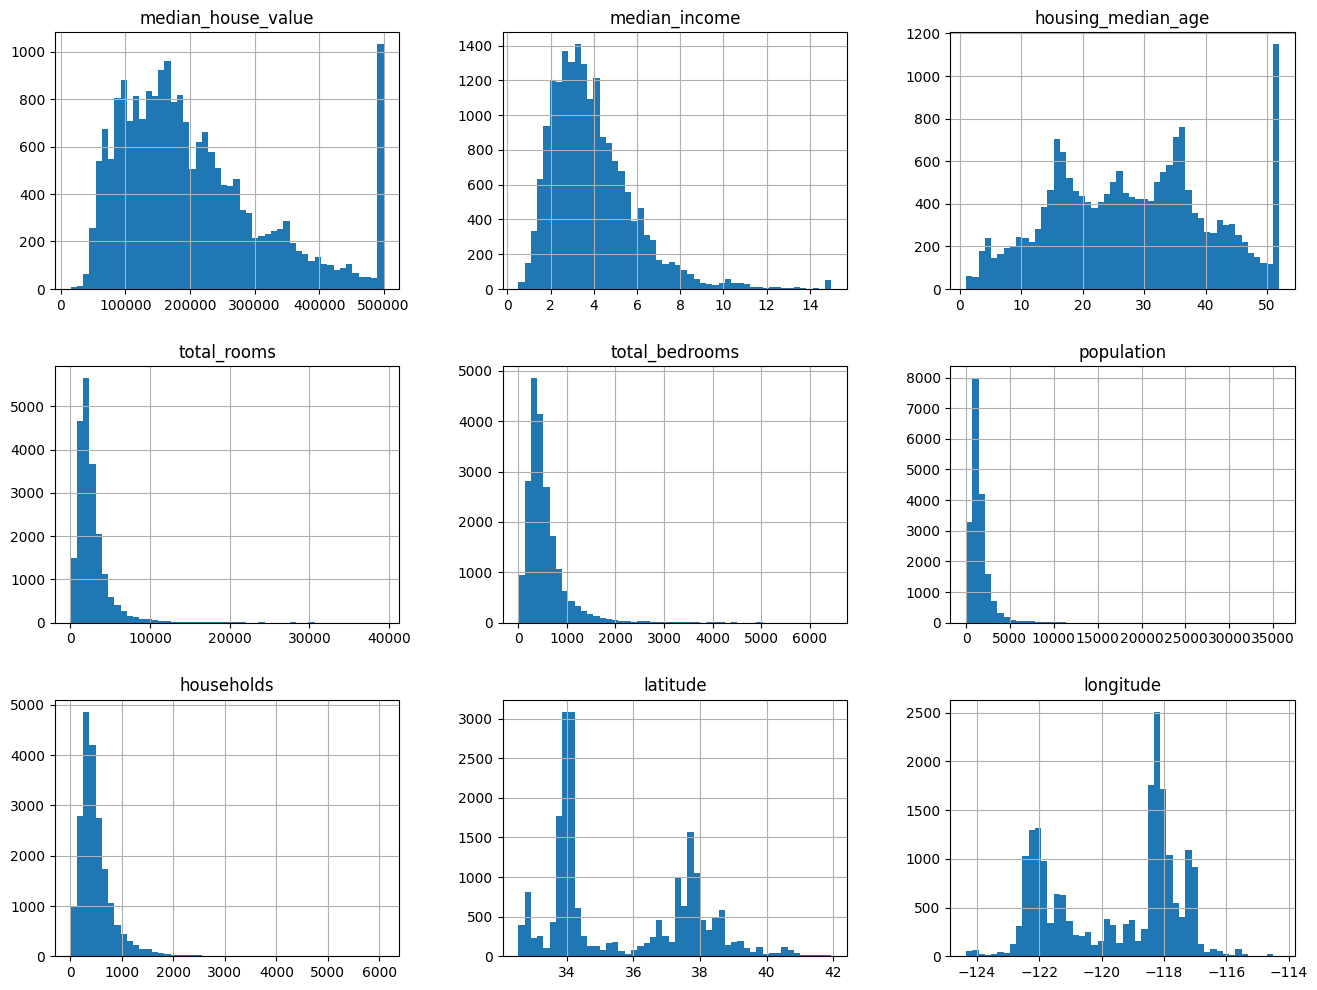

In [4]:
# We'll begin by rendering some histograms that will contextualise the numerical
# attributes of the dataset, providing an overview of the skew patterns and distributions.

houses_corrupted.hist(figsize=(16, 12), bins=50)

Upon observation we immediately see a positive skew in the majority of the attributes, such as population, median household value, and total rooms. The median income is more normally distributed, showing more symmetry about the mode than the other attributes with the potential for outliers on the higher end, and median household age may be exhibiting multimodal distribution. These skews when it comes to housing data could be a result of a variety of factors, ranging from geographical or socioeconomic, to biases withing the data collection itself. I hope to better compare at least the first group of factors over time working with this data. We also can't continue without drawing attention to the incredibly outlying modes that median house value and house median age both display, the cutoff is so sharp and precise that it suggests there was a cap to the value during data collection, house value capping at 500001 and age capping at seemingly 52 years which unfortunately limits our ability to analyze higher value properties.

In [30]:
# Checking to see what the age cap in the data is
# Find the maximum
max_age = houses_corrupted['housing_median_age'].max()

# Count the number of records with the maximum age
count_max_age = houses_corrupted[houses_corrupted['housing_median_age'] == max_age].shape[0]

print(f"Maximum age: {max_age}")
print(f"Number of records with maximum age: {count_max_age}")

Maximum age: 52.0
Number of records with maximum age: 1103


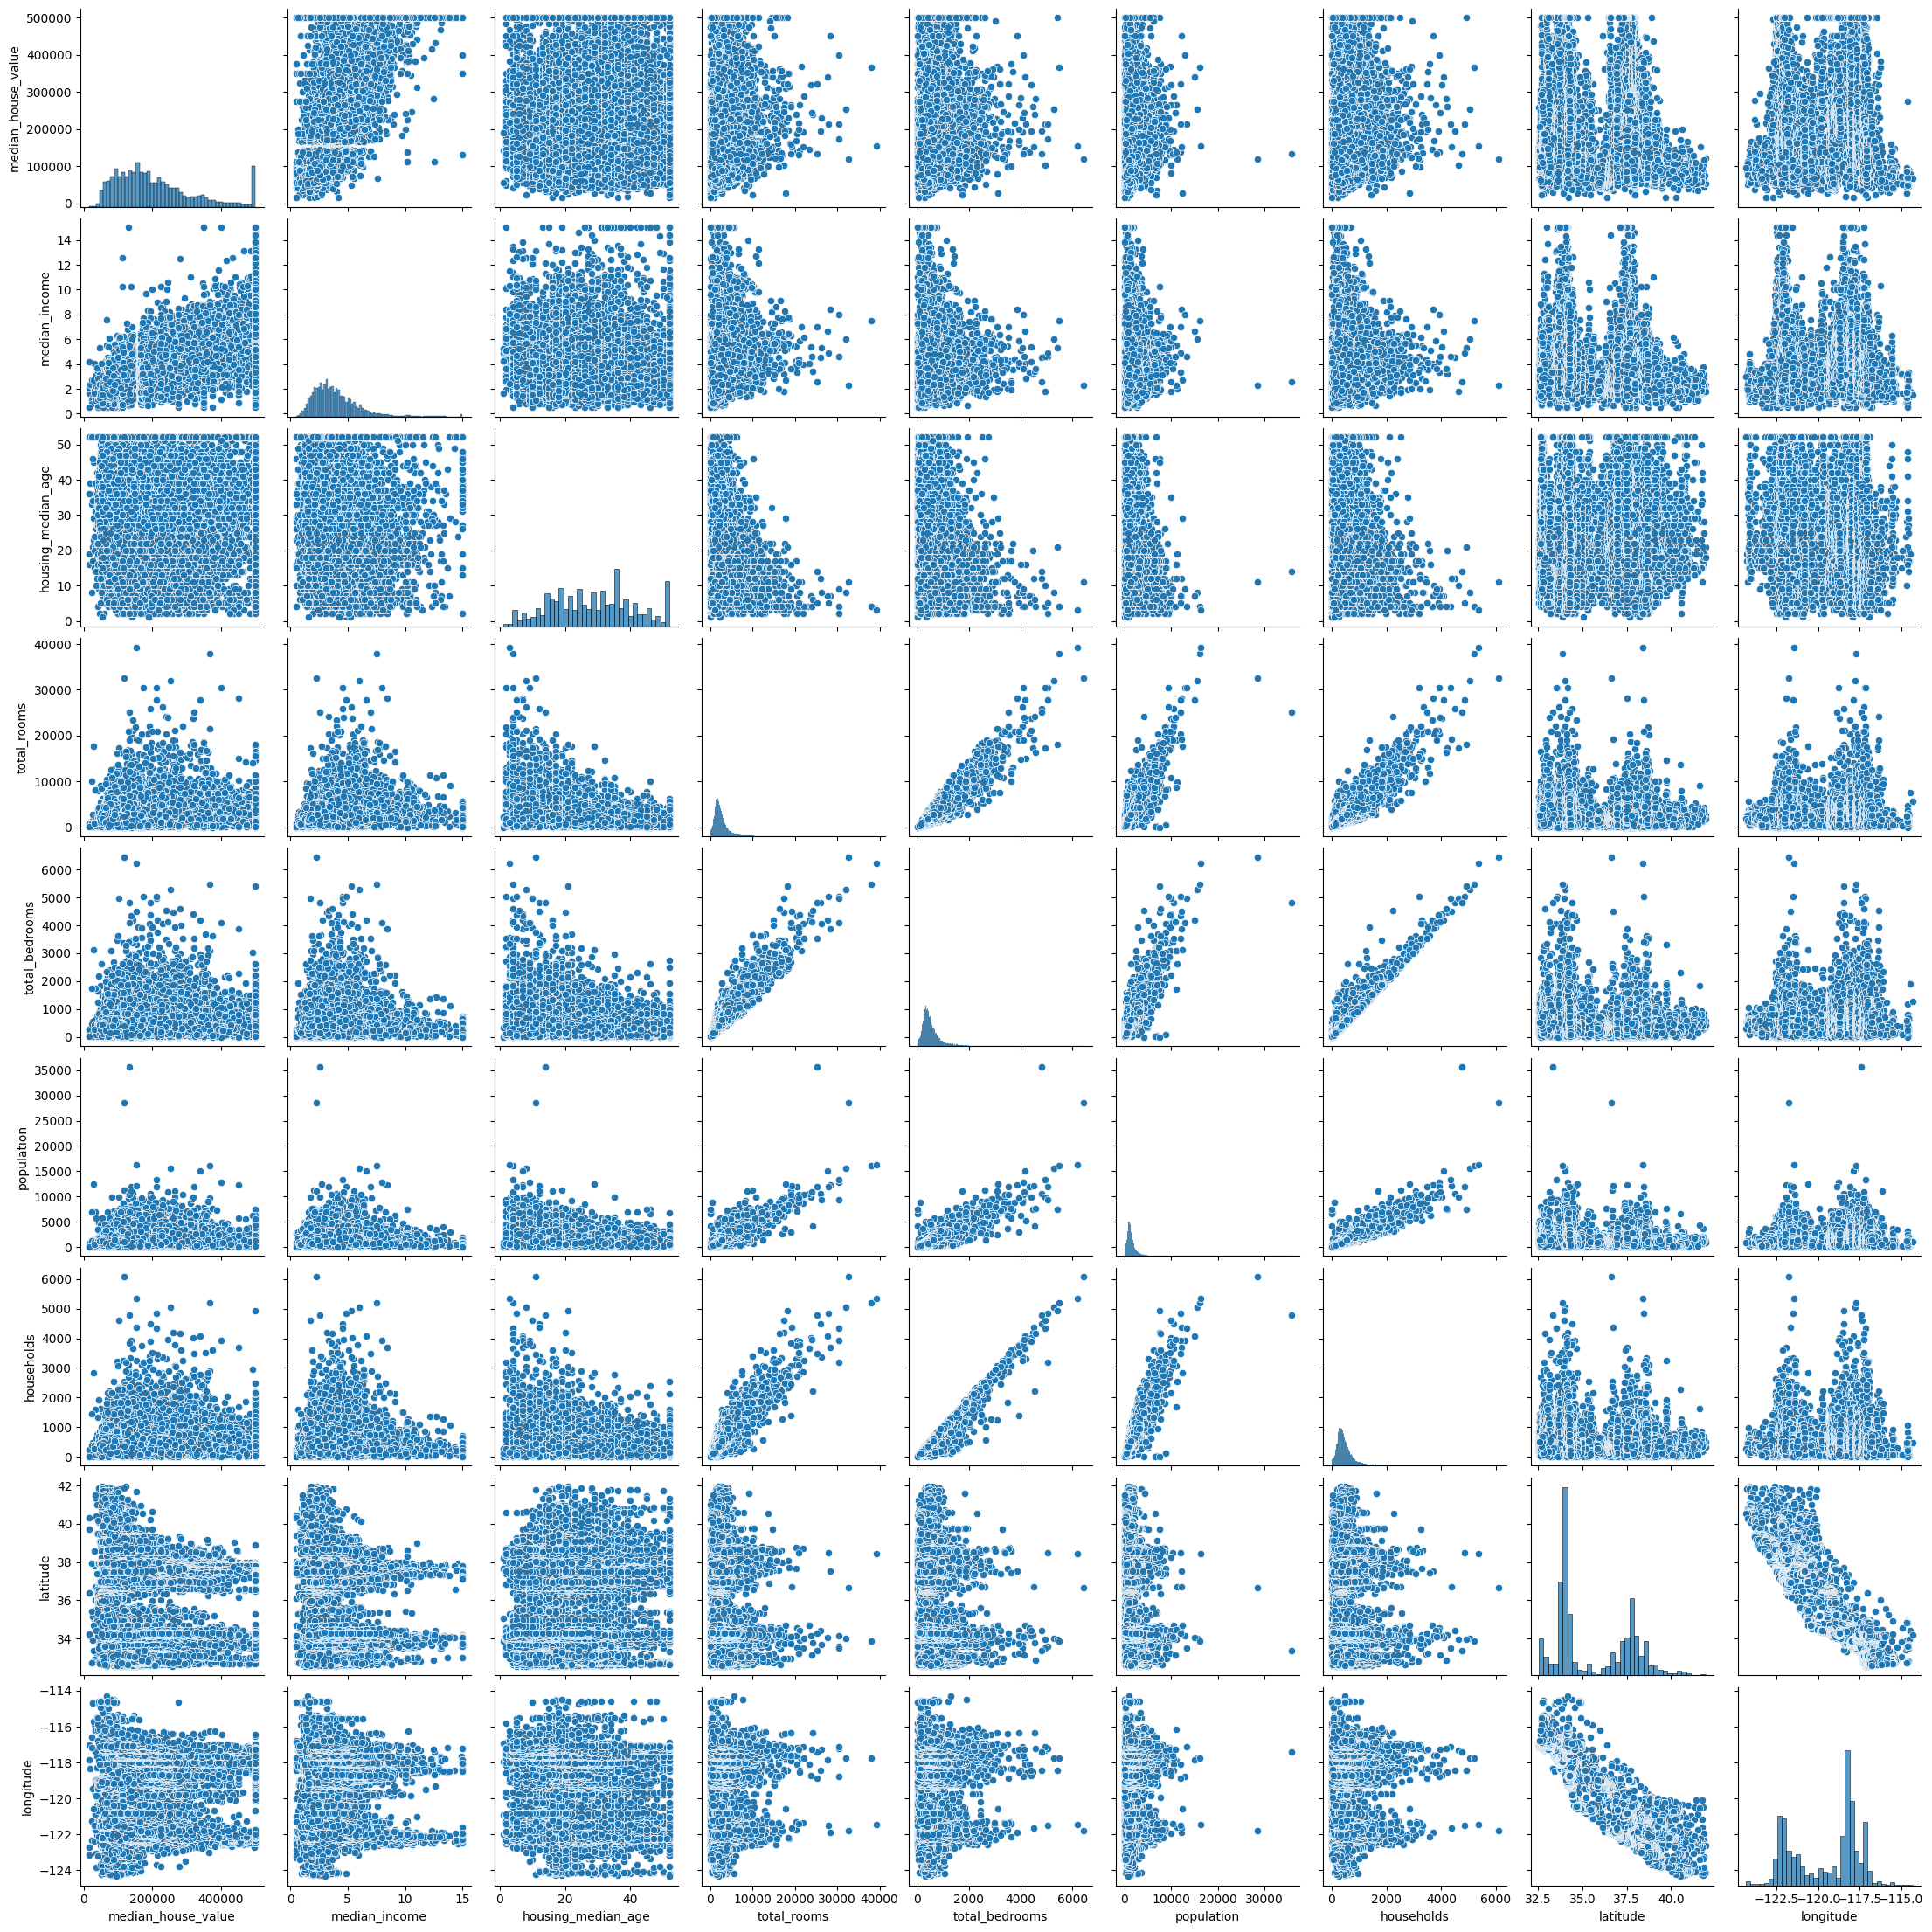

In [23]:
# To attempt to identify some of the major correlations between our attributes,
# we shall employ the aid of a pairs plot

sns.pairplot(houses_corrupted)

When looking at these pairs plots, we can see a clear positive correlation between the attributes that would naturally be expected to positively correlate, features like total rooms, bedrooms, and households all increasing with population. This intuitive relationship is clearly visualized in the scatter plots and it aligns with the logical expectation that as population density grows, so too does the demand for housing, leading to an increase in the total number of rooms, bedrooms, and households within a given area. Another prominent correlation that arises when observing the pairs plot is the bimodal peak observed in all longitude and latitude scatterplots suggesting two main population centres, with both price and population density appearing to decrease as we move away from those epicentres. The relationships visualized in the pairs plot reinforce logical trends in housing data, such as the impact of population growth on housing supply. The geographic clustering observed in latitude and longitude is particularly interesting and may reflect urban centers or regions with higher housing development.

In [29]:
# Now that we've visualised the data and made note of certain correlations
# providing real world logic as to the existence of those correlations,
# it's time to identify the attributes with values missing.

missing_values = houses_corrupted.isnull().sum()
print(missing_values)

median_house_value       0
median_income         2064
housing_median_age    2064
total_rooms              0
total_bedrooms           0
population            2064
households               0
latitude                 0
longitude                0
dtype: int64


We've clearly identified that the missing values are only within the median income, median age, and population, with the same quantitity missing from each feature, a tenth of the total values missing in each.

<Axes: >

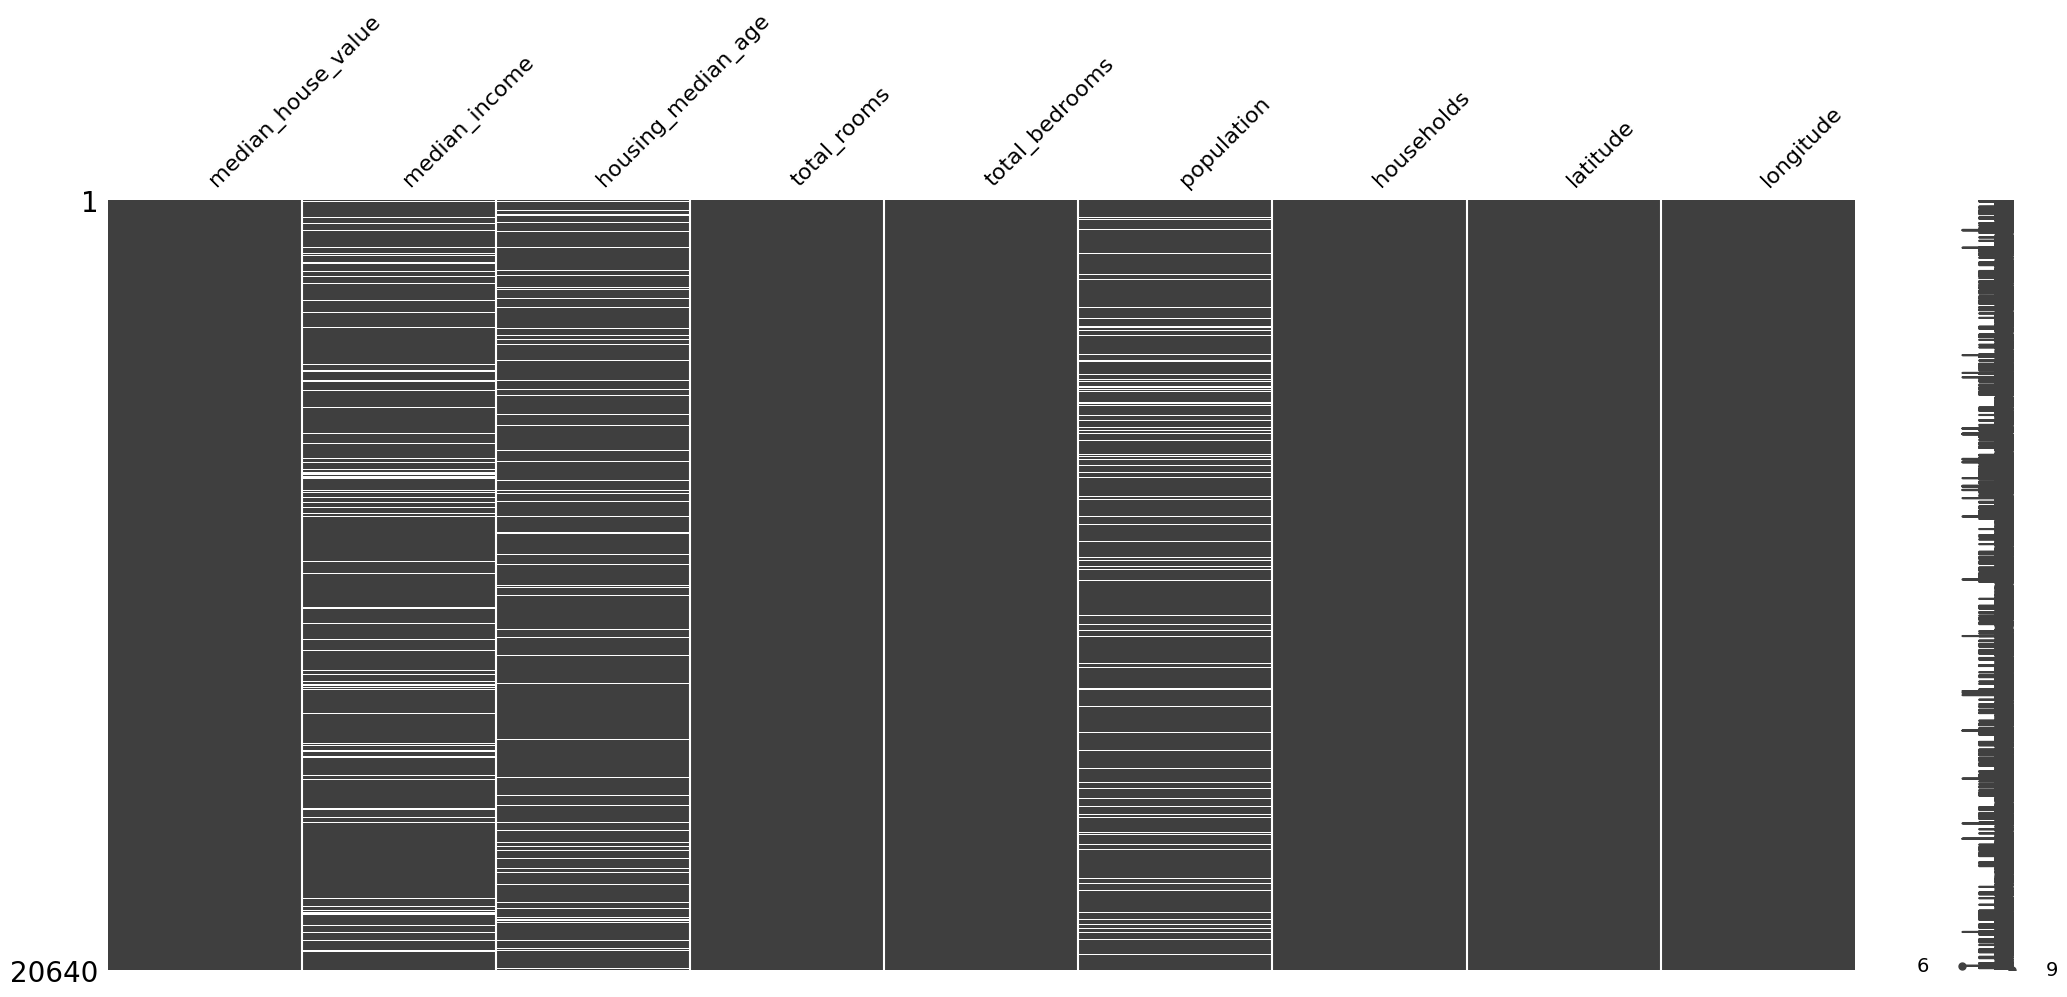

In [36]:
# Let's identify if there's any correlation between the missing values using a matrix

msno.matrix(houses_corrupted)

We can see from this matrix that the blocks of information that are missing don't necessarily line up so we can conclude that these is no pattern or strong correlation associated with any data's missingness (Missing At Random).

### Outlier Identification

We've now given the dataset a thorough analysis, identifying correlations and explaining trends. We've also made apparent the data that's missing from the set as well as having registered the most notable outliers. Those outliers however were obvious thanks to the graphs and were caused by a data recording limit, now it's time to systematically identify the rest of the outlier data. To begin with we'll take a statistical outlier detection approach by calculating robust Z-scores. The reason we're choosing this method is because it relies on the mean absolute deviation allowing it to accommodate for the skew present in nearly each variable making it more prone to detecting outliers.

In [38]:
# We will calculate the robust z-scores and display the statistics relevant to
# identifying outliers. I've experimented with the threshold and chosen to go
# with 3.0 as it balances catching meaningful outliers that were missed with 3.5
# without flagging too many like with 2.5, keeping the results clear and focused.

def robust_zscore(x):  # Defining Functions
    x = x.dropna()  # Handle missing values
    median = np.median(x)
    mad = np.median(np.abs(x - median))
    return (0.6745 * (x - median)) / mad

def summarize_robust_zscores(df, attributes, threshold=3):  # Summarising the robust Z-scores
    summaries = []  # Threshold chosen
    for col in attributes:
        if pd.api.types.is_numeric_dtype(df[col]):
            column_data = df[col].dropna()  # Drop missing values

            if column_data.empty:
                continue
            median = np.median(column_data)  # Calculate median, MAD, and robust z-scores
            mad = np.median(np.abs(column_data - median))
            robust_z = robust_zscore(column_data)

            outlier_count = np.sum(np.abs(robust_z) > threshold)  # Count outliers based on threshold

            summaries.append({
                "Column": col,
                "Median": round(median, 1),  # Round to 1dp for clarity
                "MAD": round(mad, 1),
                "Outliers": outlier_count
            })

    return pd.DataFrame(summaries)

attributes = [
    'median_house_value', 'median_income', 'housing_median_age',
    'total_rooms', 'total_bedrooms', 'population', 'households',
    'latitude', 'longitude'
]
summary_df = summarize_robust_zscores(houses_corrupted, attributes)
summary_df

Column    Median      MAD  Outliers
0  median_house_value  179700.0  68400.0      1058
1       median_income       3.6      1.1       495
2  housing_median_age      28.0      9.0         0
3         total_rooms    2127.0    797.0      1309
4      total_bedrooms     435.0    163.0      1326
5          population    1227.0    452.0      1086
6          households     409.0    151.0      1253
7            latitude      34.3      1.2       521
8           longitude    -118.5      1.3        17

The results from the statistical outlier analysis highlight some clear patterns in the dataset. Median house value flagged over 1000 outliers, indicating significant variability in property prices, likely reflecting high-value homes or distinct market segments. Similarly, total rooms and total bedrooms show the most outliers, which isn't surprising given the range of housing sizes and density in the data which suggests the presence of both small units and large-scale developments.

Median income had nearly 500 outliers, likely skewed by higher-income households, showing socio-economic diversity across the dataset. On the other hand, housing median age had no outliers at all which was the presumed result upon looking at its histogram earlier that suggested a consistent spread for this feature. Geographic attributes like latitude and longitude showed fewer outliers, with some localised extremes, but overall these variables seem more stable.

These results paint a clear picture of where the dataset's variability lies, with housing size, population, and property values standing out as the most diverse features.

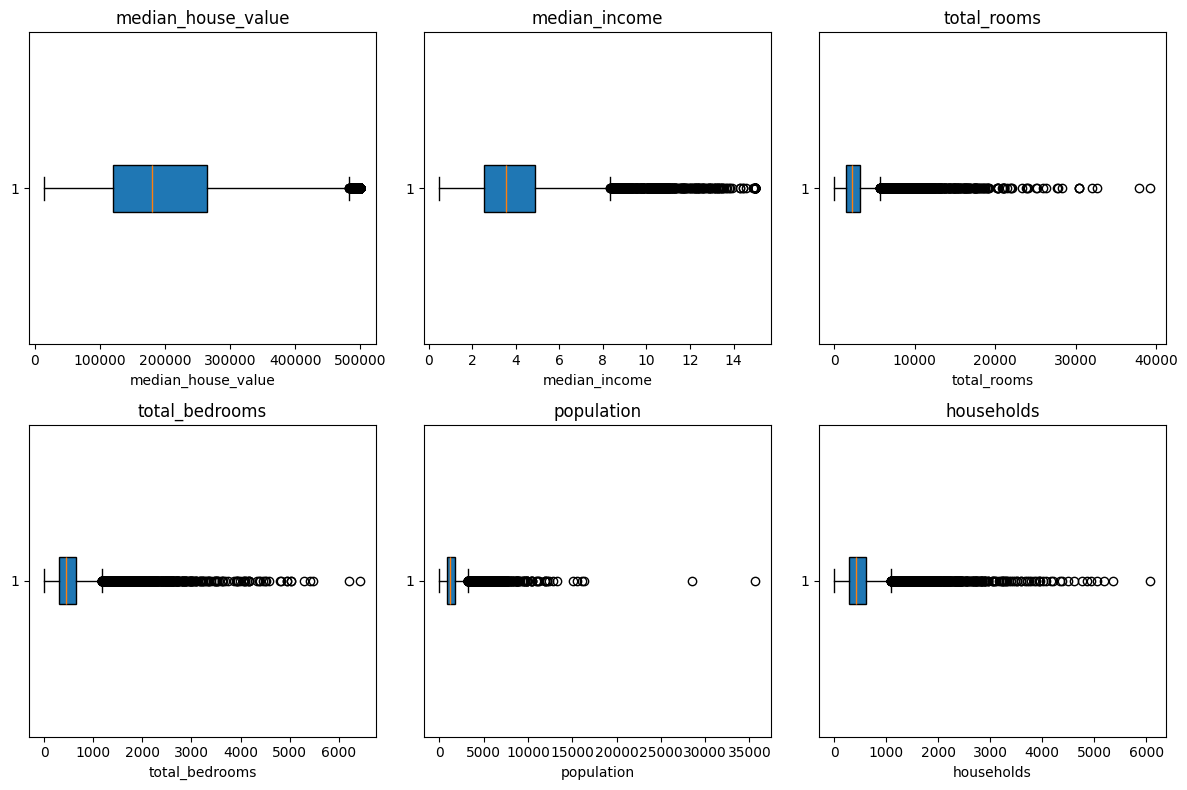

In [41]:
# Now I'm going to plot some box plots focusing on the features that either
# had a high number of outliers or had interesting variability when adjusting
# the threshold
features_to_plot = [
    'median_house_value', 'median_income', 'total_rooms',
    'total_bedrooms', 'population', 'households'
]

plt.figure(figsize=(12, 8))  # Creating box plots
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)  # Create a grid of 2 rows x 3 columns
    plt.boxplot(houses_corrupted[feature].dropna(), vert=False, patch_artist=True)
    plt.title(f'{feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()


The box plots give us a clear look at the variability and outliers across the dataset, and they match up well with what we saw using robust z-scores. For house value, all the flagged outliers are concentrated at the upper limit where the data cap of 500,001 occurs. This makes sense since the cap creates an artificial boundary, causing the most extreme values to cluster here. There are no outliers on the lower end, showing that lower house prices are more evenly distributed. For features like rooms and bedrooms, the box plots show a lot of outliers extending far beyond the whiskers, which matches the high counts we saw in the robust z-scores, the plots also show how generally skewed most of the features are.

As mentioned the robust z-score method has been great at giving us a quick and easy glance into intially understanding the dataset's variability and identifying those extreme values. It's easy to interpret and highlights where the dataset varies the most like in numbers of rooms, however while useful for flagging outliers in individual features, this method has limitations. It doesn't account for relationships between variables which we'd already established correlations for, which means it can miss outliers that are only apparent in a multivariate context.

To build on these insights, I'll move on to algorithmic methods, which can handle multivariate relationships and provide a more nuanced understanding of outliers. Comparing methods like Isolation Forest and 1Class SVM will allow me to evaluate which is most effective for this dataset and provide a more accurate identification of anomalies.

Before diving into these methods, it's important to address the capped values, as their artificial limits could influence how anomalies are detected so capped values in house value and age need to be either transformed or remmoved to ensure they don't bias the results of the algorithmic methods.

In [13]:
# I'd like to see the actual proportion of records that contain a capped
# data value to determine whether removing them would be the best course of
# action or if better to handle them separately.

# Identify rows with capped values
capped_value_rows = houses_corrupted[
    (houses_corrupted['median_house_value'] == 500001) |
    (houses_corrupted['housing_median_age'] == 52)
]

print(f"Number of rows with capped values: {len(capped_value_rows)}")

Number of rows with capped values: 1915


Capped values are present in 9.27% of our entries which is by no means an insignificant quantity and removing them would exclude a large portion of our data. Removing them could be the best course of action as their distance from the median could heavily skew our analysis, and due to how far out they lie I don't believe we'd run the risk of drawing any inaccurate conclusions without them. However due to the significance that both attributes carry in the context of the dataset I believe it would be best to proceed with an attempt to transform or rationalise these values.

As such, I believe it'd be best if we jumped to task 3, focusing on cleaning up the data before we come back to algorithmic analysis.

### Imputation
We've already identified the data with missing values, those being age, income, and population all missing 10% of their entries. None of the features have a proportion of missing values high enough to justify removal, and all are relevant in the context of the dataset so for this reason, no features will be removed. Instead, I will focus on imputing missing values for the identified features using both KNN and MICE imputation techniques to ensure the data is as complete and consistent as possible.


Missing values after KNN Imputation:
median_income         0
housing_median_age    0
population            0
dtype: int64


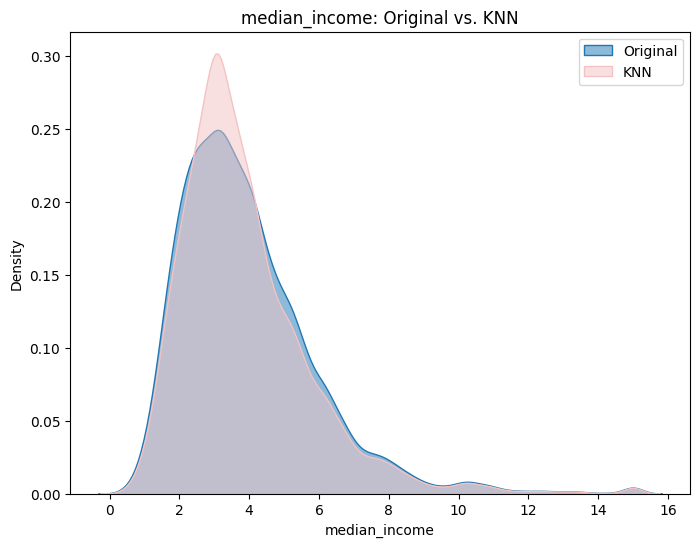

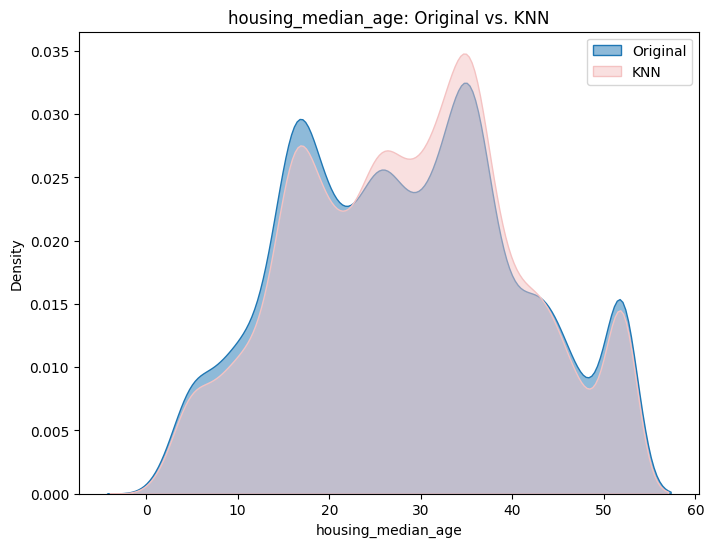

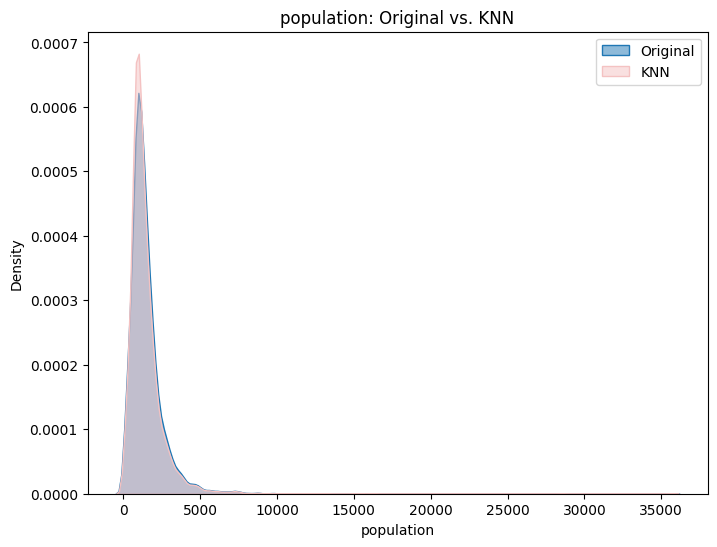

In [77]:
# Isolating the three attributes that we want to focus on
features_with_missing = ['median_income', 'housing_median_age', 'population']

knn_imputer = KNNImputer(n_neighbors=4) # Apply KNN Imputer
# Chosen n_neighbours 4 as it provided the most complete results that still
# stayed closest to the original from the values tested
knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(houses_corrupted),
    columns=houses_corrupted.columns
)

print("Missing values after KNN Imputation:") # Verifying that our imputer's filled all the missing values
print(knn_imputed[features_with_missing].isnull().sum())

# Compare distributions with KDE plots to visualise the before and afters.
# The reason I've gone with KDE plots is because they provide a smooth and
# continuous view of the data’s probability distribution, making them an ideal
# way to compare changes in the overall shape.
for feature in features_with_missing:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(houses_corrupted[feature].dropna(), label='Original', fill=True, alpha=0.5)
    sns.kdeplot(knn_imputed[feature], label='KNN', fill=True, alpha=0.5, color='#F4C2C2')
    plt.title(f"{feature}: Original vs. KNN")
    plt.legend()
    plt.show()



Missing values after MICE Imputation:
median_income         0
housing_median_age    0
population            0
dtype: int64


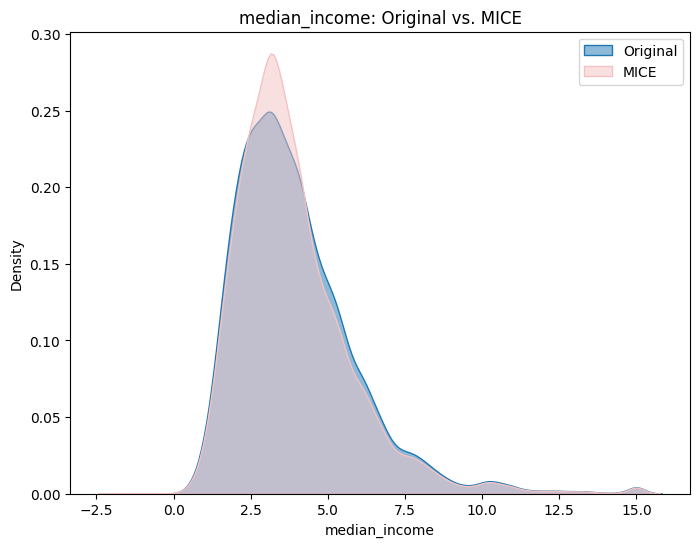

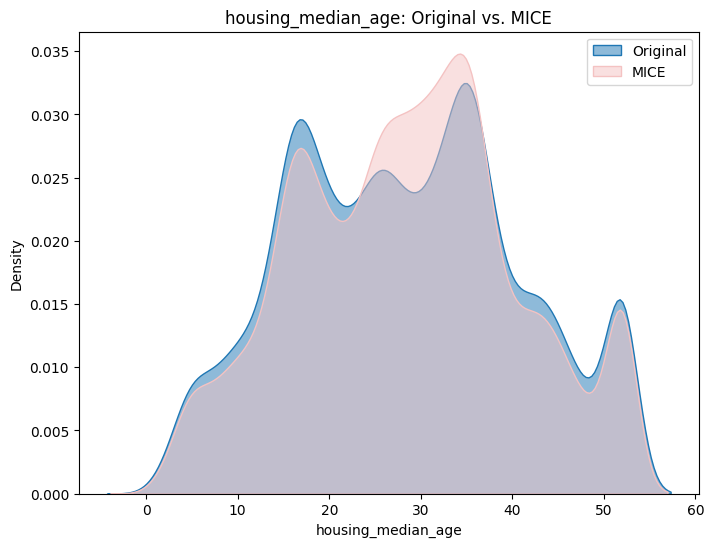

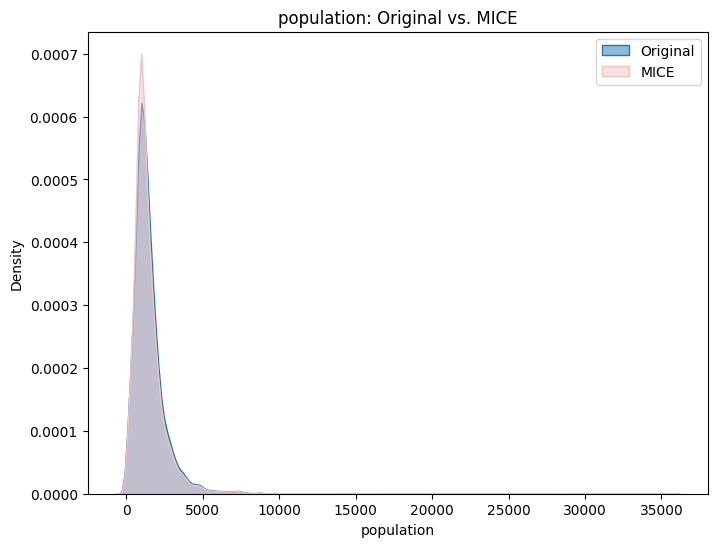

In [82]:
# Now for the MICE imputation
mice_imputer = IterativeImputer(max_iter=10, random_state=100)
mice_imputed = pd.DataFrame(
    mice_imputer.fit_transform(houses_corrupted),
    columns=houses_corrupted.columns
)

print("Missing values after MICE Imputation:")  # Check all values filled
print(mice_imputed[features_with_missing].isnull().sum())

for feature in features_with_missing:  # Draw KDE graph like in KNN
    plt.figure(figsize=(8, 6))
    sns.kdeplot(houses_corrupted[feature].dropna(), label='Original', fill=True, alpha=0.5)
    sns.kdeplot(mice_imputed[feature], label='MICE', fill=True, alpha=0.5, color='#F4C2C2')
    plt.title(f"{feature}: Original vs. MICE")
    plt.legend()
    plt.show()

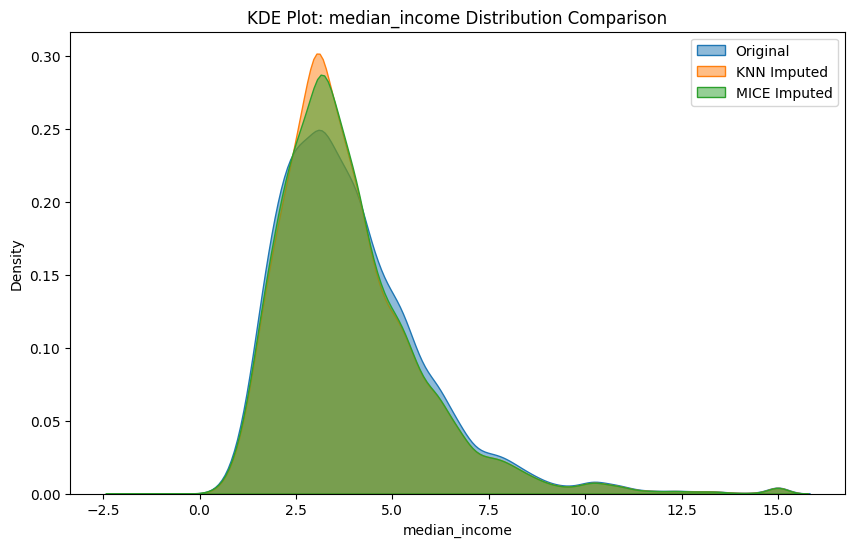

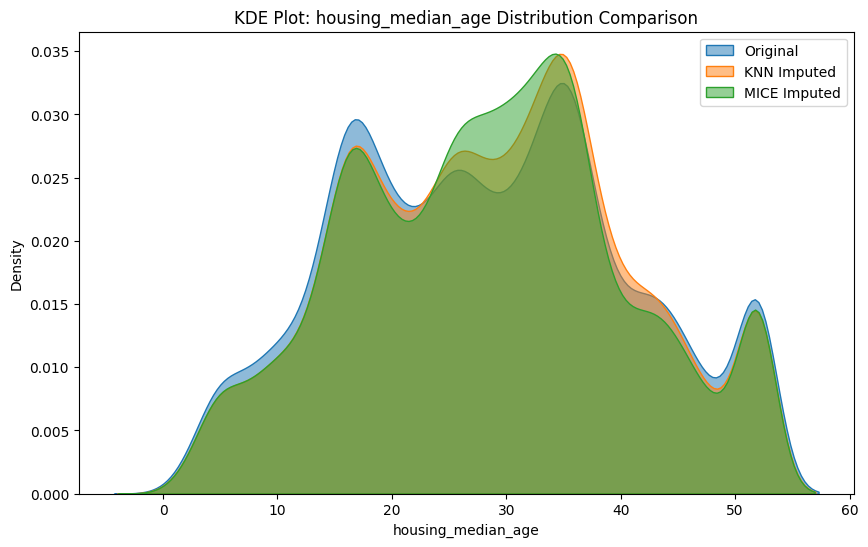

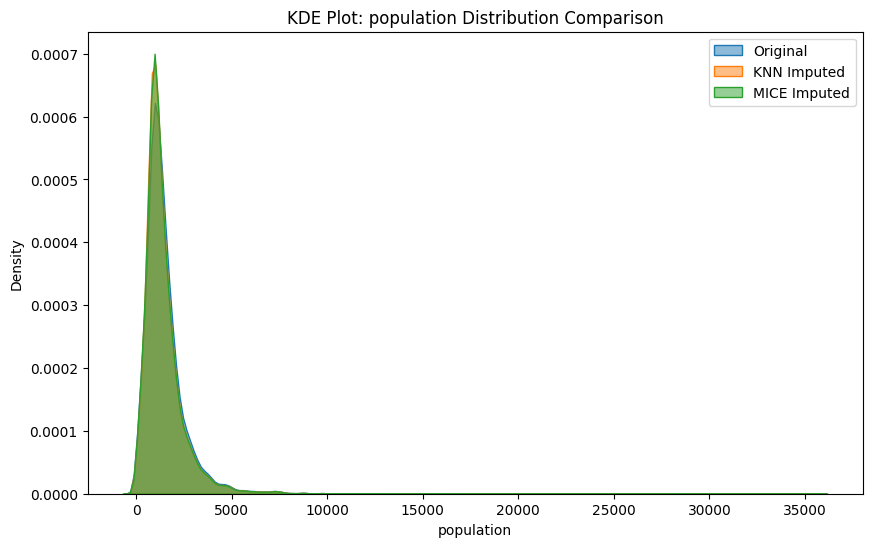

median_income  housing_median_age  population  KNN_median_income  \
count       18576.00            18576.00    18576.00           20640.00   
mean            3.93               28.32     1488.07               3.86   
std             1.96               12.58     1170.59               1.88   
min             0.50                1.00        3.00               0.50   
25%             2.56               18.00      839.00               2.62   
50%             3.57               28.00     1227.00               3.48   
75%             4.87               37.00     1803.00               4.68   
max            15.00               52.00    35682.00              15.00   

       KNN_housing_median_age  KNN_population  MICE_median_income  \
count                20640.00        20640.00            20640.00   
mean                    28.68         1425.35                3.86   
std                     12.17         1128.51                1.89   
min                      1.00            3.00               -1.67   
25%                     19.00          807.00                2.60   
50%                     29.00         1154.00                3.50   
75%                     37.00         1714.00                4.69   
max                     52.00        35682.00               15.00   

       MICE_housing_median_age  MICE_population  
count                 20640.00         20640.00  
mean                     28.48          1422.85  
std                      12.02          1130.24  
min                       1.00          -232.58  
25%                      19.00           811.00  
50%                      29.00          1152.00  
75%                      36.00          1714.00  
max                      52.00         35682.00

In [95]:
# Now that we've imputed with KNN and MICE, it's time to compare both methods
features_to_compare = ['median_income', 'housing_median_age', 'population']

for feature in features_to_compare:  # Plot KDE graphs with all data overlapping
    plt.figure(figsize=(10, 6))
    sns.kdeplot(houses_corrupted[feature].dropna(), label='Original', fill=True, alpha=0.5)
    sns.kdeplot(knn_imputed[feature], label='KNN Imputed', fill=True, alpha=0.5)
    sns.kdeplot(mice_imputed[feature], label='MICE Imputed', fill=True, alpha=0.5)
    plt.title(f"KDE Plot: {feature} Distribution Comparison")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

original_stats = houses_corrupted[features_to_compare].describe()  # Display table of stats
knn_stats = knn_imputed[features_to_compare].describe().add_prefix('KNN_')
mice_stats = mice_imputed[features_to_compare].describe().add_prefix('MICE_')

comparison_stats = pd.concat([original_stats, knn_stats, mice_stats], axis=1)
comparison_stats = comparison_stats.round(2)
comparison_stats

The graphs provide a clear comparison between the original dataset and the two imputed versions (KNN and MICE,) with both imputation methods successfully handle the missing data. However the summary statistics show there are noticeable differences in how they affect the dataset's central tendencies, variability, and range.

For income, the mean and median in both KNN (3.86, 3.48) and MICE (3.86, 3.50) are slightly lower than in the original dataset (3.93, 3.57) suggesting that both methods impute slightly lower values, which could be a result of smoothing or regression effects. KNN reduces variability a little more, with a standard deviation of 1.88 compared to MICE at 1.89, while the original dataset retains the highest variability (1.96). Bizarrely, MICE introduces a small number of unrealistic negative values (-1.67 minimum), clearly brought on by its regression based approach but may warrant re-examination.

For age, MICE better preserves the original distribution's complexity. The mean for MICE (28.48) is closer to the original dataset (28.32) than KNN (28.68), and MICE also retains more variability, with a standard deviation of 12.02 compared to KNN at 12.17. Both methods slightly increase the median value to 29.00 from the original 28.00, but the shift is more noticeable with KNN, likely due to its smoothing tendency.

For population, the mean and median are lower in both imputed datasets than in the original (1488.07, 1227.00). KNN (1425.35, 1154.00) and MICE (1422.85, 1152.00) suggest a slight downward shift in population values. Variability is also reduced, with standard deviations of 1128.51 (KNN) and 1130.24 (MICE) compared to 1170.59 in the original dataset. Notably, MICE again introduces a negative minimum value (-232.58), which is even less possible than when it did so for income.

KNN performs well for features like income and population, producing consistent and realistic values while slightly smoothing variability. However, its tendency to over-smooth makes it less effective for features like age, which exhibit more complex distributions. MICE, on the other hand, retains more variability and aligns better with the original dataset's structure, particularly for features with multimodal distributions like housing_median_age. That said, the introduction of negative values in income and population is a drawback that could influence later analysis and are very explicit outliers.

### Outlier Identification

Now that we've imputed the missing values, it's important to revisit outlier detection before moving on to regression modeling. Imputation can sometimes introduce new anomalies or exaggerate existing ones—like the negative population values in the MICE-imputed dataset. It's a good time to move back to algorithmic outlier detection as if these outliers aren't addressed, they could skew the regression models and lead to unreliable predictions. We'll proceed with the Isolation Forest detection algorithm.

In [107]:
# Function to apply Isolation Forest and flag outliers
def detect_outliers_with_iforest(dataset, contamination=0.05):
    numeric_features = dataset.select_dtypes(include=['float64', 'int64']).columns
    iforest = IsolationForest(contamination=contamination, random_state=100)
    dataset['Outlier'] = iforest.fit_predict(dataset[numeric_features])
    return dataset

# Apply Isolation Forest to KNN and MICE datasets
knn_outliers = detect_outliers_with_iforest(knn_imputed.copy())
mice_outliers = detect_outliers_with_iforest(mice_imputed.copy())

# Count the number of outliers detected
knn_outlier_count = (knn_outliers['Outlier'] == -1).sum()
mice_outlier_count = (mice_outliers['Outlier'] == -1).sum()

print(f"KNN Outliers: {knn_outlier_count}")
print(f"MICE Outliers: {mice_outlier_count}")


KNN Outliers: 1032
MICE Outliers: 1032


Both datasets have the exact same number of flagged outliers which suggests that while the imputation methods differ (KNN smoothing vs. MICE regression), the overall distribution of the data post-imputation is structurally similar.
This still doesn't necessarily mean the flagged outliers are the same rows in both datasets. Some may overlap, while others may differ due to artifacts introduced during imputation.

In [108]:
# Let's try and better understand these outliers
overlap = set(knn_outliers[knn_outliers['Outlier'] == -1].index) & \
          set(mice_outliers[mice_outliers['Outlier'] == -1].index)
print(f"Number of overlapping outliers: {len(overlap)}")


Number of overlapping outliers: 966


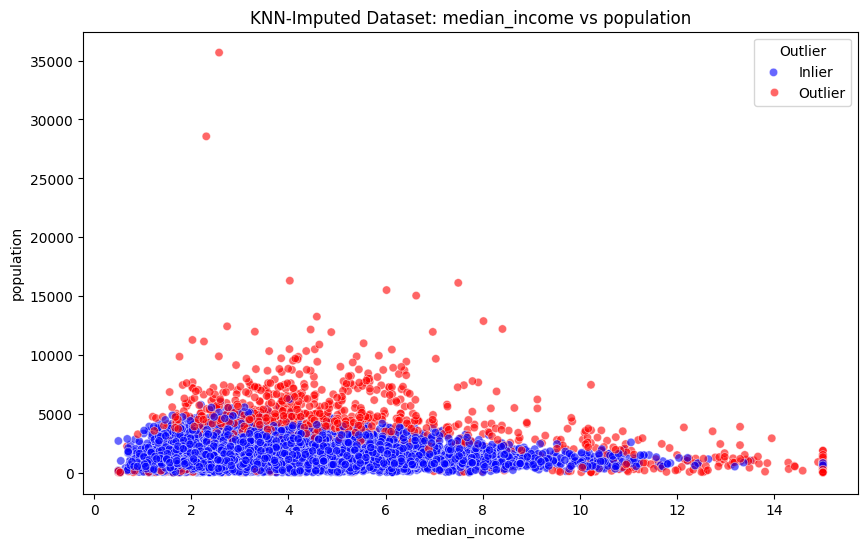

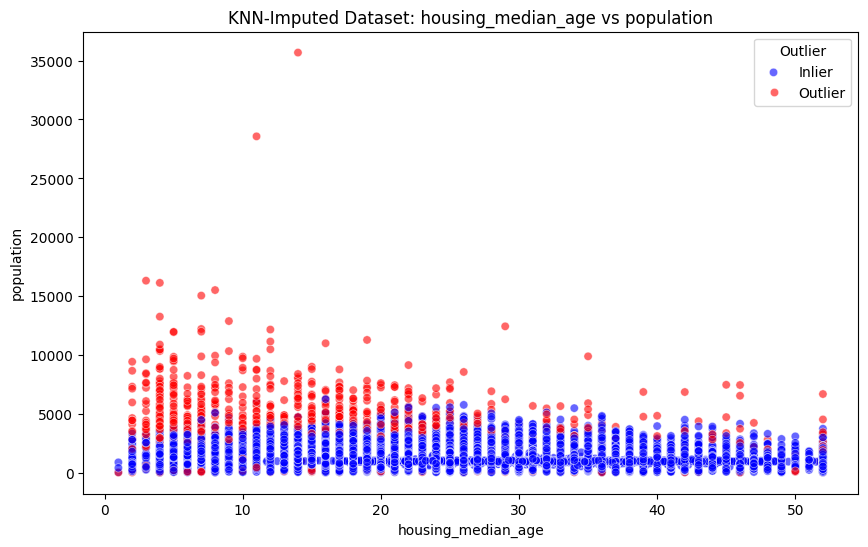

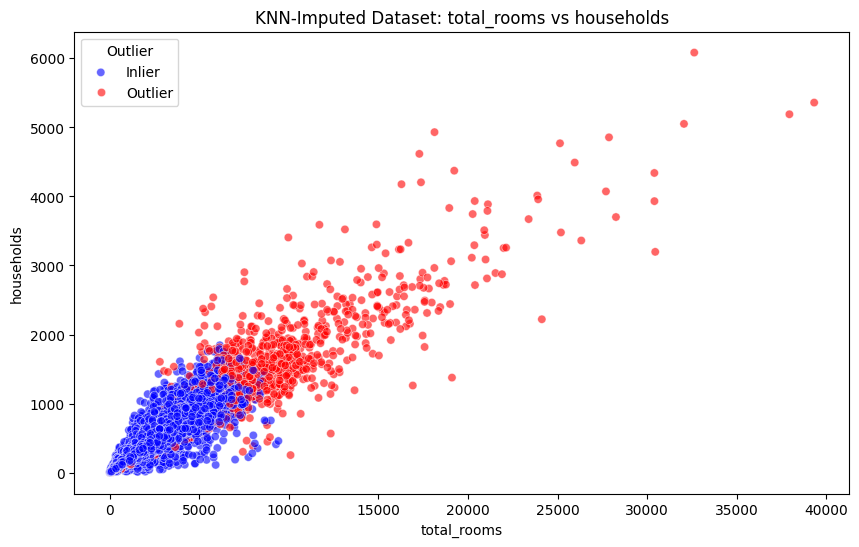

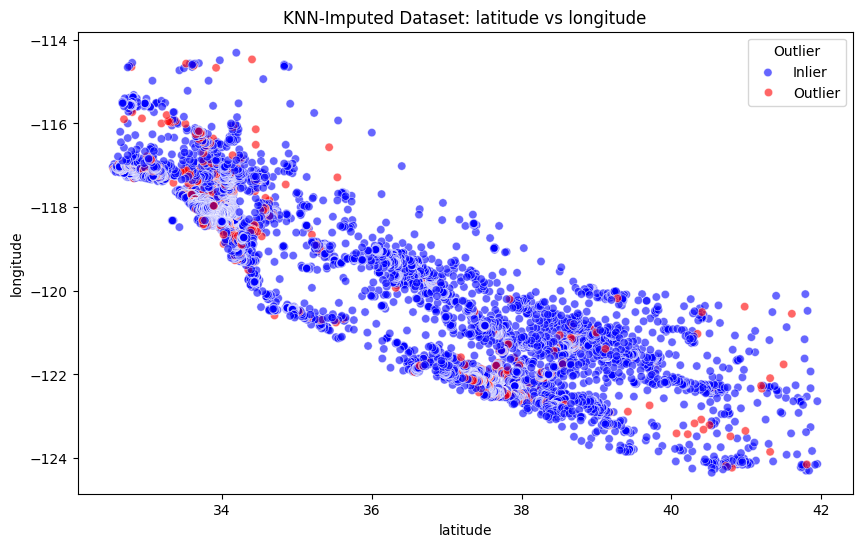

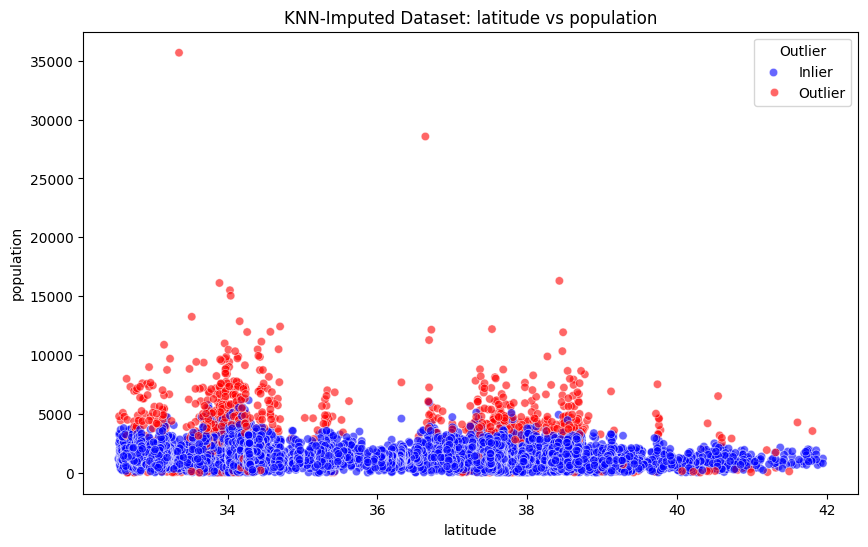

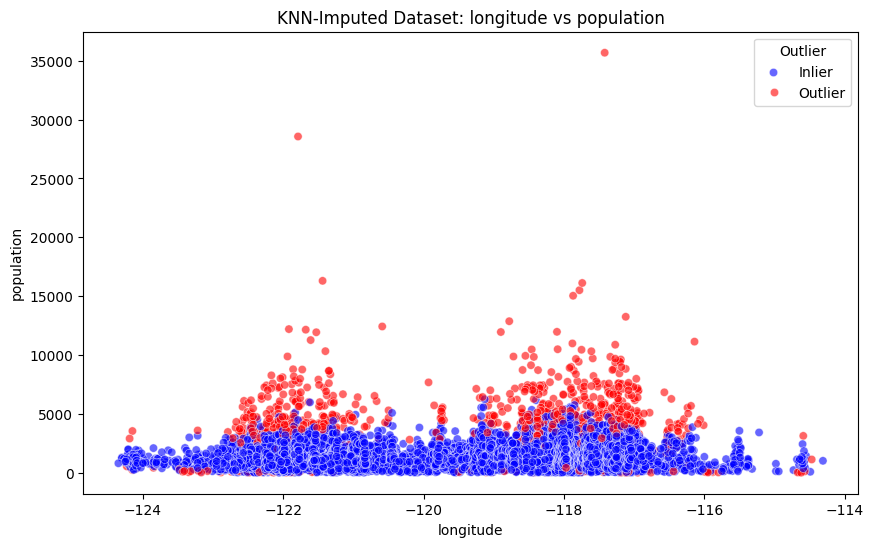

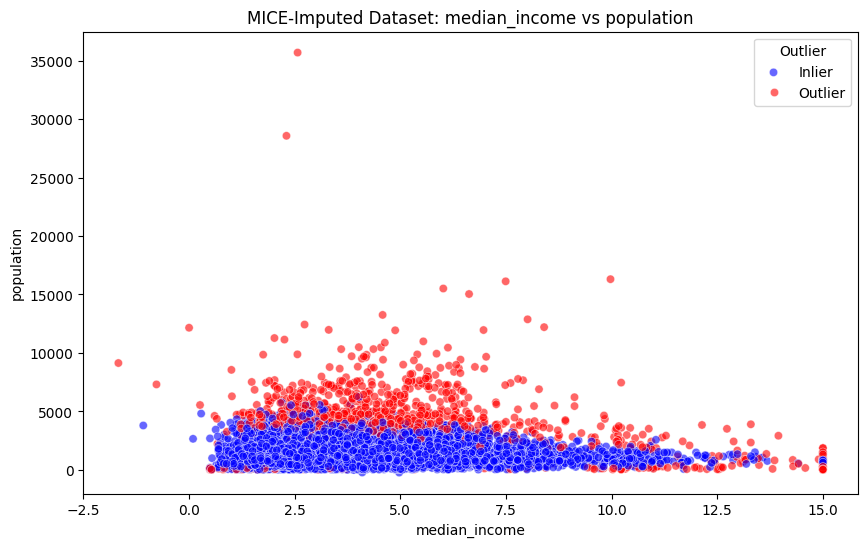

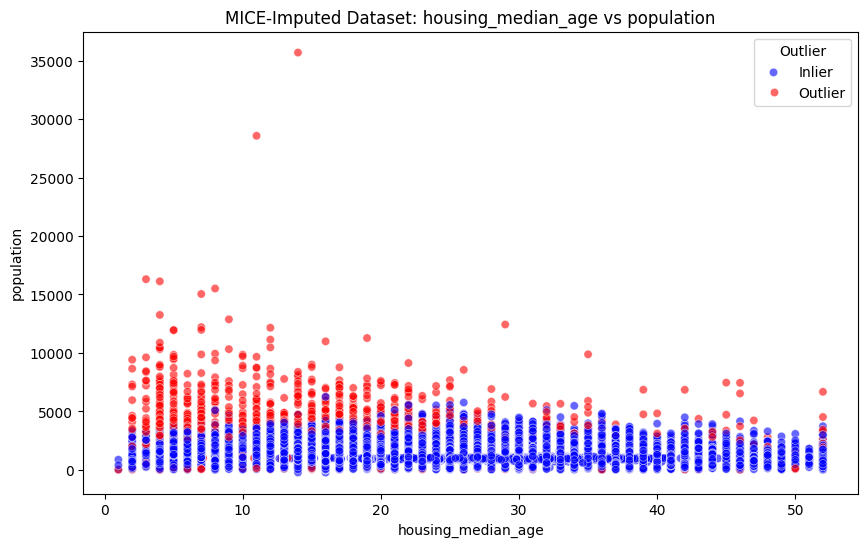

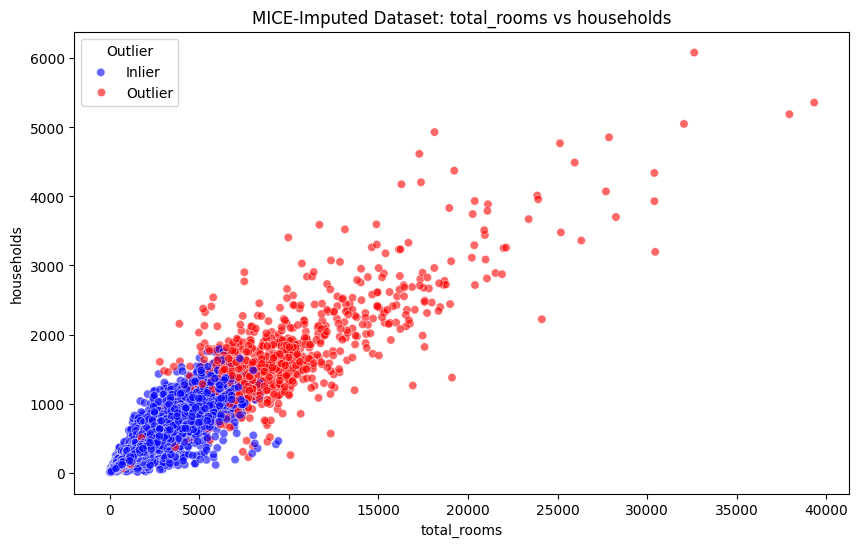

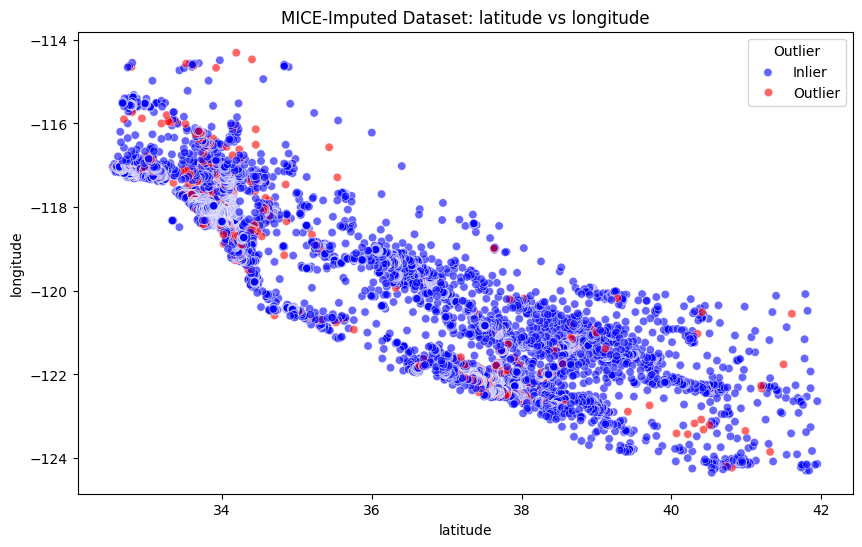

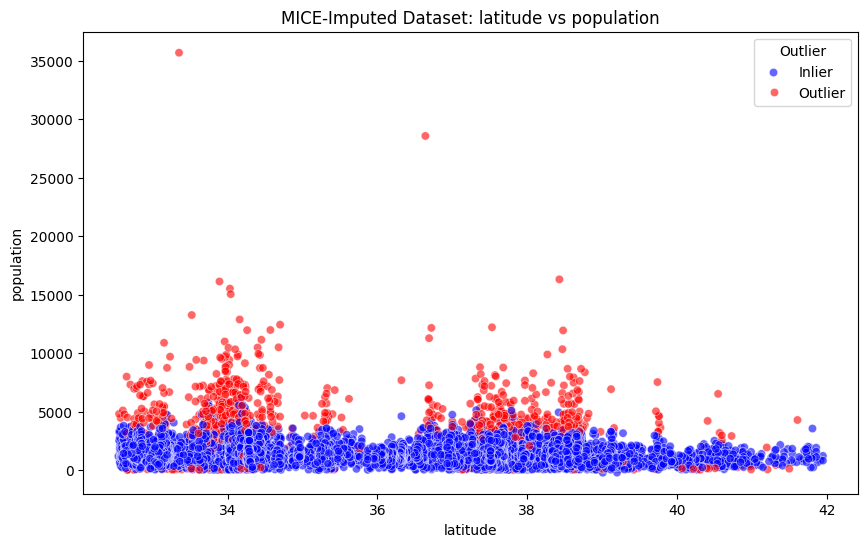

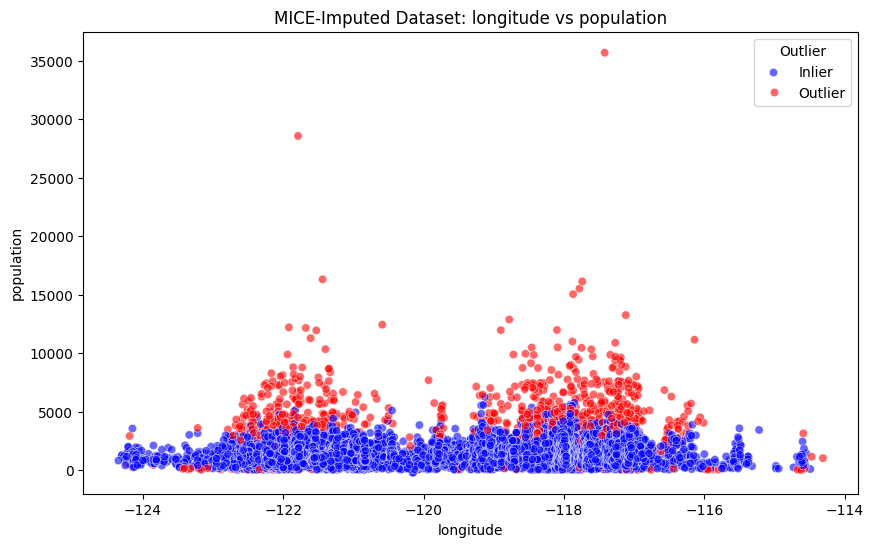

In [114]:
# Scatter plot function to visualize outliers
def plot_isolation_forest(dataset, x_feature, y_feature, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=dataset,
        x=x_feature,
        y=y_feature,
        hue='Outlier',
        palette={1: 'blue', -1: 'red'},
        alpha=0.6
    )
    plt.title(title)
    plt.legend(title='Outlier', labels=['Inlier', 'Outlier'])
    plt.show()

# Key features to visualize
feature_pairs = [
    ('median_income', 'population'),
    ('housing_median_age', 'population'),
    ('total_rooms', 'households'),
    ('latitude', 'longitude'),
    ('latitude', 'population'),
    ('longitude', 'population')
]

# Plot for KNN dataset
for x_feature, y_feature in feature_pairs:
    plot_isolation_forest(knn_outliers, x_feature, y_feature, f"KNN-Imputed Dataset: {x_feature} vs {y_feature}")

# Plot for MICE dataset
for x_feature, y_feature in feature_pairs:
    plot_isolation_forest(mice_outliers, x_feature, y_feature, f"MICE-Imputed Dataset: {x_feature} vs {y_feature}")


The scatterplots provide a clear visualization of the outliers flagged by Isolation Forest in the KNN and MICE-imputed datasets. In both datasets, patterns of outliers are consistent across many feature pairs, such as income vs. population, where flagged values represent extremely high-income groups or densely populated areas.

For geographical features like latitude and longitude, the flagged outliers highlight regions with unusual housing characteristics, likely influenced by location-based economic or demographic factors. In feature pairs like total rooms vs. households, the outliers reflect atypical housing density, further emphasizing the importance of identifying and addressing these anomalies.

These visualizations confirm that while many outliers overlap between the two datasets, the imputation method significantly affects the nature of unique anomalies. The next step involves deciding whether to remove or transform these outliers to ensure robust regression modeling.

Outlier detection has now been performed using both a statistical approach (robust z-scores) and an algorithmic approach (Isolation Forest). The statistical method flagged numerous univariate outliers in features like total rooms and population, reflecting their skewed distributions. While effective for identifying extreme values, this approach does not consider multivariate relationships and overflags features influenced by data collection caps.

Isolation Forest addressed these limitations by capturing multivariate anomalies, flagging 1,032 outliers in both KNN and MICE datasets. High overlap between the two (966 shared outliers) suggests consistent patterns post-imputation, while unique anomalies highlight differences introduced by each method.

Moving forward, imputation artifacts (e.g., negative population) will be removed, and extreme but valid values will be transformed where necessary. This step ensures clean, robust datasets for regression modeling.

In [140]:
# Here we'll clean data by removing artifacts and capping extreme values
def clean_dataset(dataset, cap_limits):
    cleaned_data = dataset.copy()

    # Remove negative values (e.g., artifacts in MICE-imputed data)
    for col in cap_limits.keys():
        cleaned_data = cleaned_data[cleaned_data[col] >= 0]

    # Cap extreme values
    for col, (min_val, max_val) in cap_limits.items():
        cleaned_data[col] = cleaned_data[col].clip(lower=min_val, upper=max_val)

    return cleaned_data

# Define cap limits for relevant features (based on domain knowledge or observed distributions)
cap_limits = {
    'median_income': (0.5, 15),
    'population': (0, 35000),
    'total_rooms': (0, 20000),
    'total_bedrooms': (0, 5000),
    'households': (0, 5000),
}

# Clean KNN and MICE datasets
knn_cleaned = clean_dataset(knn_imputed, cap_limits)
mice_cleaned = clean_dataset(mice_imputed, cap_limits)

print(f"KNN Dataset after cleaning: {knn_cleaned.shape}")
print(f"MICE Dataset after cleaning: {mice_cleaned.shape}")


KNN Dataset after cleaning: (20640, 9)
MICE Dataset after cleaning: (20634, 9)


### Imputation

Now we come back to task 3 and build our regressor

In [148]:
features = ['median_income', 'housing_median_age', 'total_rooms',
            'total_bedrooms', 'population', 'households',
            'latitude', 'longitude']
target = 'median_house_value'

# Now we train and evaluate a linear regression model
def evaluate_linear_model(dataset, features, target):
    X = dataset[features]
    y = dataset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = round(mean_absolute_error(y_test, y_pred))
    r2 = round(r2_score(y_test, y_pred), 4)

    return {'MAE': mae, 'R-squared': r2}

# Use the original uncorrupted dataset for evaluation
uncorrupted_metrics = evaluate_linear_model(houses, features, target)
# Drop the empty values in the corrupted set to prevent errors
houses_corrupted_cleaned = houses_corrupted.dropna()
# Evaluate the datasets
original_metrics = evaluate_linear_model(houses_corrupted_cleaned, features, target)
knn_metrics = evaluate_linear_model(knn_cleaned, features, target)
mice_metrics = evaluate_linear_model(mice_cleaned, features, target)

# Print results compared with the original
print("Corrupted Dataset Metrics:", original_metrics)
print("KNN-Imputed Dataset Metrics:", knn_metrics)
print("MICE-Imputed Dataset Metrics:", mice_metrics)
print("Uncorrupted Dataset Metrics:", uncorrupted_metrics)

Corrupted Dataset Metrics: {'MAE': 52273, 'R-squared': 0.6534}
KNN-Imputed Dataset Metrics: {'MAE': 49595, 'R-squared': 0.6613}
MICE-Imputed Dataset Metrics: {'MAE': 48645, 'R-squared': 0.6536}
Uncorrupted Dataset Metrics: {'MAE': 49989, 'R-squared': 0.6581}


### Conclusions and Thoughts
I've ensured that my thoughts were effectively communicated and recorded throughout this task which allows me to consolidate them now as I begin to record my conlusions. I explored various methods for anomaly detection and imputation to address the challenges posed by a corrupted dataset, each approach had its strengths and weaknesses, and understanding these was important for making informed decisions about data cleaning and preparation.

For anomaly detection, I began with a statistical approach using robust Z-scores. This method was quick and effective for identifying univariate outliers, especially in a dataset like this one, where many features exhibited skewed distributions. However, it became clear that robust Z-scores could not capture outliers that arise from relationships between features. To address this, I turned to Isolation Forest, which provided a more sophisticated, multivariate approach. Isolation Forest was particularly useful for identifying subtle anomalies influenced by multiple features, but it wasn't without challenges. Choosing the right contamination rate required experimentation, and validating whether the flagged points were true anomalies or valid extreme values often depended on domain context. For example, deciding how to handle the capped house values required careful thought on the data's origins.

Imputation brought its own challenges, especially when trying to assess the differences between KNN and MICE. KNN was relatively easy to comprehend conceptually, it fills in missing values based on averages from the nearest neighbors but when reviewing the imputed data, I sometimes questioned whether the smoothing effect had altered the true characteristics of the dataset. For example, distributions of features like housing age appeared flatter after KNN imputation, and I wasn't immediately sure if that was a reasonable result. MICE, on the other hand, was more complex to grasp because of its iterative approach. While it produced results that seemed more nuanced and better preserved relationships between features, I found myself double-checking whether the iterative imputation process introduced any unintended artifacts. At times, unexpected values in the imputed data like negative populations left me wondering if I had misconfigured the process or if these were artifacts inherent to the method.

Comparing the datasets revealed the impact of imputation on model performance, but interpreting the regression results also posed challenges. Metrics like MAE and R-squared were easy to calculate, but I found it harder to connect these numbers back to the data preparation steps. For example, while MICE consistently outperformed KNN and the corrupted dataset, understanding exactly why it worked better required me to think critically about the multivariate relationships it preserved. Similarly, seeing the corrupted dataset perform reasonably well despite its missing data initially confused me until I realized that the rows with missing values were likely less critical for prediction as I had deliberated about much much earlier in this project. This process of connecting the dots between preprocessing steps and regression outcomes was one of the most valuable learning experiences in the task.

Overall, this coursework highlighted how much thought and care is required in data preparation. While computational tools make it easy to apply methods like Isolation Forest or MICE, understanding their outputs and deciding what to do with them is not always straightforward. I found that being iterative in my approach (testing methods, reviewing results, and refining my decisions) was key to making progress. This experience has given me a deeper appreciation for the nuances of working with real-world data and the critical role that judgment plays in ensuring high-quality analysis.